# 生成对抗网络

生成模型的作用是学习一个概率分布$P_{model}(X)$并按这个概率分布生成数据

## 1. 自动编码器(Autoencoders)
应用：1.数据去噪 2.可视化降维

作为压缩算法的特点：
1. 与数据相关程度很高，使用植物训练的自编码器用于提取动物的特征，会得到很差的结果
2. 压缩编码后的数据是有损的
<center>自动编码器</center>
<img src='image/autoencoder.jpg' height='50%' width='50%'>
上图是一个自编码器的整体架构图(出自CS231n课件)，损失函数是原图像与重构图像间的L2距离，编解码器均使用卷积神经网络来实现

### 1.1 数据预处理

In [1]:
import os
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

use_cuda = torch.cuda.is_available()                    # gpu可用
device = torch.device('cuda' if use_cuda else 'cpu')    # 优先使用gpu

In [2]:
# 设置超参数(Hyperparameters)
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

In [3]:
# 1.读取数据及预处理
# Compose将各种预处理操作组合，ToTensor将图片处理为tensor，
# Normalize(mean, variance)正则化
data_tf = transforms.Compose([transforms.ToTensor(),                 # 数据变为tensor，范围[0,1]
                              transforms.Normalize([0.5], [0.5])])   # 缩放到[-1,1]
# 下载MNIST手写数字训练集
train_dataset = datasets.MNIST(root='./data/MNIST', train=True, transform=data_tf, download=False)
test_dataset = datasets.MNIST(root='./data/MNIST', train=False, transform=data_tf)
# 创建数据迭代器便于训练模型
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
print('1.训练数据的维度:')
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)
print('2.测试数据的维度:')
print(test_dataset.test_data.shape)
print(test_dataset.test_labels.shape)

1.训练数据的维度:
torch.Size([60000, 28, 28])
torch.Size([60000])
2.测试数据的维度:
torch.Size([10000, 28, 28])
torch.Size([10000])


1.0~9样本的索引: [1, 4, 17, 2, 6, 18, 3, 0, 28, 11]


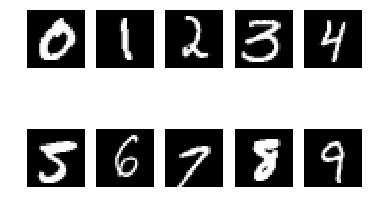

In [5]:
# 显示数据
%matplotlib inline
def show_image():
    test = test_dataset.test_labels.numpy()     # 将tensor数据转换为numpy数据
    print(np.where(test==1))
    sample_index = [np.where(test==i)[0][1] for i in range(10)] # np.where的输出(array([], dtype),)
    print('1.0~9样本的索引:', sample_index)
    sample_data = test_dataset.test_data[sample_index]          # 获取10个样本数据
    print('2.手写体样本:')
    for i in range(10):
        plt.subplot(2,5,i+1)
        sample_data = test_dataset.test_data[sample_index][i]    # torch.Size([28, 28])
#         print(sample_data.shape)
        plt.axis("off")       # 关掉坐标轴
        plt.imshow(sample_data, interpolation='none', cmap='gray')
# show_image()
def show_image2():
#     x,y = train_loader.__iter__().next()   # 通过数据迭代器访问数据
    x, y = next(train_loader.__iter__())
    x, y = map(lambda x:x.numpy(), [x, y])   # 将tensor转换为numpy数据
    sample_index = [np.where(y==i)[0][0] for i in range(10)]
    print('1.0~9样本的索引:',sample_index)
    for i in range(10):
        plt.subplot(2,5,i+1)
        sample_data = x[sample_index][i,0]    # (28,28)
        plt.axis('off')
        plt.imshow(sample_data, cmap='gray')
show_image2()

### 1.2 定义自编码器模型

In [6]:
# 定义模型
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()                   # 继承类的初始化  
        self.encoder = nn.Sequential(        # 编码器部分 input (N, 1, 28, 28)
            nn.Linear(28*28, 128),           # (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),              # (N, 64)
            nn.ReLU(),
            nn.Linear(64, 12),               # (N, 12)
            nn.ReLU(),
            nn.Linear(12, 3)                 # (N, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),                # (N, 12)
            nn.ReLU(),
            nn.Linear(12, 64),               # (N, 64)
            nn.ReLU(),
            nn.Linear(64, 128),              # (N, 128)
            nn.Linear(128, 28*28),           # (N, 28*28)
            nn.Tanh()                        # 将数据缩放到 (-1,1)，与输入的数据范围对应!!!
        )
    def forward(self, x):
        x = x.view(-1, 28*28)                # 将数据reshape为 (N, 28*28)
        x = self.encoder(x)                  # 编码器
        x = self.decoder(x)                  # 解码器
        x = x.view(-1, 28, 28)               # (N, 28, 28)
        return x
    
    def encode(self, x):                    # 输入数据维度    (N, 1, 28, 28)
        x = x.view(-1, 28*28)                # 将数据reshape为 (N, 28*28)
        x = self.encoder(x)                  # 编码器          (N, 3)
        return x
    def decode(self, x):                    # 输入数据维度    (N,3)
        x = self.decoder(x)                  # 解码器
        x = x.view(-1, 28, 28)               # (N, 28, 28)
        return x

### 1.3 添加损失、优化器并进行训练

In [7]:
# 设置损失函数及优化器
autoencoder = AutoEncoder().to(device)
# print(autoencoder)
criterion = nn.MSELoss()        # 均方差损失就是L2距离损失
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [8]:
%%time
# 开始训练模型
num_epochs = 20
pltX, pltY = [], []
epoch_end = len(train_loader) - 1
for epoch in range(num_epochs):
    print('------------Epoch:%d-------------' % epoch)
    pltX.append(epoch)
    for iteration, data in enumerate(train_loader):
        x, _ = data                               # 读入图像数据，只是用x就行
        x = x.to(device)                          # 转换数据类型
#         x = x.type(torch.cuda.FloatTensor)

        out = autoencoder(x)                      # (N, 28, 28)
        loss = criterion(out, x.squeeze())        # 计算L2损失
#         print(loss)
        print_loss = loss.data.item()             # tensor转换为一个数
        
        # 优化模型
        optimizer.zero_grad()                     # 梯度归零
        loss.backward()                           # 反向传播
        optimizer.step()                          # 更新参数
        
        if iteration % 500 == 0 or iteration == epoch_end:
            print('Iter:{:<5} loss:{:.4f}'.format(iteration, loss.data))
    pltY.append(print_loss)

------------Epoch:0-------------
Iter:0     loss:0.9356
Iter:468   loss:0.2046
------------Epoch:1-------------
Iter:0     loss:0.1945
Iter:468   loss:0.1734
------------Epoch:2-------------
Iter:0     loss:0.1798
Iter:468   loss:0.1601
------------Epoch:3-------------
Iter:0     loss:0.1626
Iter:468   loss:0.1596
------------Epoch:4-------------
Iter:0     loss:0.1692
Iter:468   loss:0.1357
------------Epoch:5-------------
Iter:0     loss:0.1513
Iter:468   loss:0.1593
------------Epoch:6-------------
Iter:0     loss:0.1517
Iter:468   loss:0.1570
------------Epoch:7-------------
Iter:0     loss:0.1418
Iter:468   loss:0.1535
------------Epoch:8-------------
Iter:0     loss:0.1636
Iter:468   loss:0.1486
------------Epoch:9-------------
Iter:0     loss:0.1455
Iter:468   loss:0.1570
------------Epoch:10-------------
Iter:0     loss:0.1472
Iter:468   loss:0.1316
------------Epoch:11-------------
Iter:0     loss:0.1402
Iter:468   loss:0.1512
------------Epoch:12-------------
Iter:0     loss:

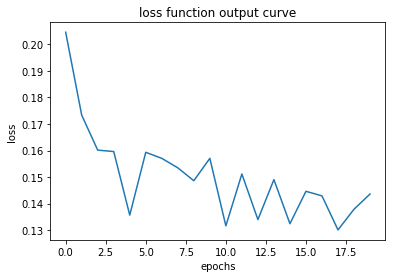

In [9]:
# 绘制loss曲线
plt.title('loss function output curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(pltX, pltY)
plt.show()

损失函数很难看，但整体是在下降的，如果增加批次大的大小，或训练更多的epoch可以画出较平滑的图像

### 1.4 测试与评估模型

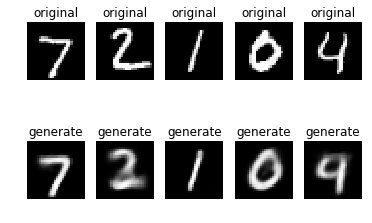

In [10]:
# 测试模型性能
autoencoder.eval()                              # 模型进入测试模式
test_x, _ = next(test_loader.__iter__())        # torch.Size([64, 1, 28, 28])
# print(test_x.shape)
test_x = test_x.to(device)
with torch.no_grad():
    out = autoencoder(test_x)
#     print(out.shape)
scale = lambda x:(x-x.min())/(x.max()-x.min())   # 将范围归一化到[0,1]
test_x, out = map(scale, [test_x, out])          # 将数值范围缩放到[0,1]便于显示
show_number = 5
for i in range(show_number):

    # 绘制测试的原图
    plt.subplot(2, show_number, i+1)
    plt.title('original')
    test_x_img = test_x[i,0]                     # (28,28)
    plt.axis('off')
    plt.imshow(test_x_img, cmap='gray')
    
    # 绘制生成的原图
    plt.subplot(2, show_number, show_number+i+1)
    plt.title('generate')
    out_x_img = out[i]
    plt.axis('off')
    plt.imshow(out_x_img, cmap='gray')

总结：
1. 解码器部分输出一定要缩放到(-1,1)范围，经过一个tanh()非线性函数处理就行

### 基于卷积的自编码器
使用全连接层作为编码和解码器会丢失一些空间信息，导致重构的图像轮廓是模糊的，使用卷积神经网络会得到更好的效果，使轮廓更加清晰
$$out = (input-1)*s+w-2*p$$

In [11]:
# 定义基于CNN的自编码器
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(                                # input (N, 1, 28, 28)
            nn.Conv2d(1, 16, kernel_size=3, stride=3, padding=1),    # (N,16,10,10)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                               # (N,16,5,5)
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),    # (N,8,3,3)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)                                # (N,8,2,2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),      # (N,16,5,5)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),       # (N,8,15,15)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),        # (N,1,28,28)
            nn.Tanh()                                                # 缩放数据到 (-1,1) 
        )        
        self._init_weights()                                         # 初始化权重和偏置
        
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight.data)
                nn.init.zeros_(m.bias.data)

In [12]:
cnn_autoencoder = AutoEncoderCNN().to(device)
criterion = nn.MSELoss()    # L2损失
optimizer = optim.Adam(cnn_autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

In [13]:
%%time
# 开始训练模型
num_epochs = 40
pltX, pltY = [], []
epoch_end = len(train_loader) - 1
for epoch in range(num_epochs):
    print('------------Epoch:%d-------------' % epoch)
    for iteration, data in enumerate(train_loader):
        x, _ = data                               # 读入图像数据，只是用x就行
        x = x.to(device)                          # 转换数据类型
#         x = x.type(torch.cuda.FloatTensor)

        _, out = cnn_autoencoder(x)               # (N,1,28, 28)
        loss = criterion(out, x)               # 计算L2损失
#         print(loss)
        print_loss = loss.data.item()             # tensor转换为一个数
        
        # 优化模型
        optimizer.zero_grad()                     # 梯度归零
        loss.backward()                           # 反向传播
        optimizer.step()                          # 更新参数
        
        if iteration % 500 == 0 or iteration == epoch_end:
#             pltX.append(epoch)
            pltY.append(print_loss)
            print('Iter:{:<5} loss:{:.4f}'.format(iteration, loss.data))
save_image(out, './image/autoencoder_sample.png')

------------Epoch:0-------------
Iter:0     loss:0.8545
Iter:468   loss:0.2585
------------Epoch:1-------------
Iter:0     loss:0.2531
Iter:468   loss:0.1529
------------Epoch:2-------------
Iter:0     loss:0.1499
Iter:468   loss:0.1295
------------Epoch:3-------------
Iter:0     loss:0.1215
Iter:468   loss:0.1269
------------Epoch:4-------------
Iter:0     loss:0.1259
Iter:468   loss:0.1066
------------Epoch:5-------------
Iter:0     loss:0.1224
Iter:468   loss:0.1149
------------Epoch:6-------------
Iter:0     loss:0.1081
Iter:468   loss:0.1118
------------Epoch:7-------------
Iter:0     loss:0.1089
Iter:468   loss:0.1084
------------Epoch:8-------------
Iter:0     loss:0.1141
Iter:468   loss:0.1071
------------Epoch:9-------------
Iter:0     loss:0.1054
Iter:468   loss:0.1073
------------Epoch:10-------------
Iter:0     loss:0.1002
Iter:468   loss:0.1021
------------Epoch:11-------------
Iter:0     loss:0.1038
Iter:468   loss:0.1040
------------Epoch:12-------------
Iter:0     loss:

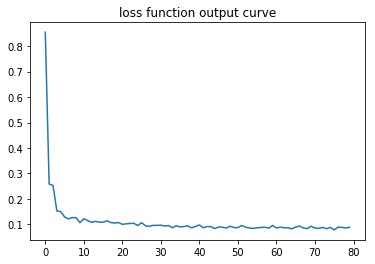

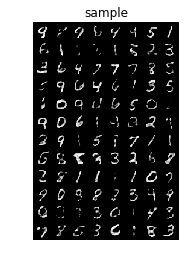

In [14]:
# 绘制loss曲线
import imageio        # 读取图像
plt.title('loss function output curve')
plt.plot(pltY)    # 每500个迭代记录一次loss
plt.show()
img = imageio.imread('./image/autoencoder_sample.png')       # (H,W,C)
plt.title('sample')
plt.axis('off')
plt.imshow(img)
plt.show()

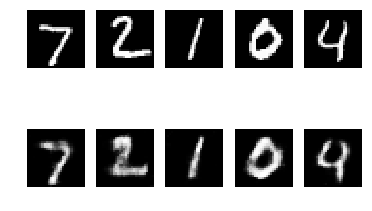

In [15]:
# 测试模型性能
cnn_autoencoder.eval()                              # 模型进入测试模式
test_x, _ = next(test_loader.__iter__())        # torch.Size([64, 1, 28, 28])
# print(test_x.shape)
test_x = test_x.to(device)
with torch.no_grad():
    _, out = cnn_autoencoder(test_x)
#     print(out.shape)
scale = lambda x:(x-x.min())/(x.max()-x.min())   # 将范围归一化到[0,1]
test_x, out = map(scale, [test_x, out])          # 将数值范围缩放到[0,1]便于显示
show_number = 5
for i in range(show_number):

    # 绘制测试的原图
    plt.subplot(2, show_number, i+1)
#     plt.title('original')
    test_x_img = test_x[i,0]                     # (28,28)
    plt.axis('off')
    plt.imshow(test_x_img, cmap='gray')
    
    # 绘制生成的原图
    plt.subplot(2, show_number, show_number+i+1)
#     plt.title('generate')
    out_x_img = out[i,0]
    plt.axis('off')
    plt.imshow(out_x_img, cmap='gray')

总结
1. 每个样本的损失为 $\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2$，一般**MSE损失**是将各批次的损失取平均即    
$$\ell = \frac{1}{N}\sum_{i=1}^N(x_i - y_i)^2$$    
使用`nn.MSELoss()`可以实现上述公式(默认)

2. **L2损失**公式：
$$\ell =\|x-y\|^2 = \sum_{i=1}^N(x_i - y_i)^2$$
使用`nn.MSELoss(reduction='sum')`表示没有除以N的操作，直接将该批次中各数据的损失$(x_i - y_i)^2$累加，实际中一般会**除以2**，在计算梯度的时候可以使系数变为1，参考[tensorflow l2_loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss)
3. 损失函数输出的标量值大小与回传的梯度大小有关，所以最后的损失与学习率乘积的结果回传后可以有效的更新权重，在SGD中损失函数大小可能影响比较大，但Adam算法中有归一化梯度的过程，所以损失值的大小对算法影响较小